In [1]:
from scipy.io import mmread
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import gzip
import shutil
import json
import matplotlib
import os

ModuleNotFoundError: No module named 'xb'

# Domain identification

## functions for banksy 

In [42]:
## modify the X coords of each sample so that they are processed independently
def adapt_banksy_for_multisample(adata):
    adata.obs['Xres']=adata.obs['x_centroid']
    adata.obs['Yres']=adata.obs['y_centroid']
    gap=adata.obs['x_centroid'].max()+int(adata.obs['x_centroid'].max()/10)
    samplekey='sample'
    counter=0
    sampsel=[]
    for s in adata.obs[samplekey].unique():
        sampsel.append(s)
        adata.obs.loc[~adata.obs[samplekey].isin(sampsel),'Xres']=adata.obs.loc[~adata.obs[samplekey].isin(sampsel),'Xres']+gap
        counter=counter+1
    adata.obs['Yres']=adata.obs['Yres']+1
    adata.obsm['spatial_sample_specific']=adata.obsm['spatial']
    adata.obsm['spatial']=np.array(adata.obs.loc[:,['Xres','Yres']])
    return adata
def define_palette(n_colors=50):
    from random import randint
    colorlist = []
    n = n_colors
    for i in range(n):
        colorlist.append('#%06X' % randint(0, 0xFFFFFF))
    return colorlist

def domains_by_banksy(adata,plot_path:str,banksy_params:dict):
    adata=adapt_banksy_for_multisample(adata)
    coord_keys = ('Xres', 'Yres','spatial')
    prev_clusters=[e for e in adata.obs.columns if clustering_params['clustering_alg'] in e]
    if len(prev_clusters)>0:
        annotation_key=prev_clusters[0]
    else:
        adata.obs['default_clustering']='0'
        adata.obs['default_clustering']=adata.obs['default_clustering'].astype('category')
        annotation_key='default_clustering'
        

    banksy_dict = initialize_banksy(
        adata,
        coord_keys,
        banksy_params['k_geom'],
        nbr_weight_decay=banksy_params['nbr_weight_decay'],
        max_m=banksy_params['max_m'],
        plt_edge_hist=True,
        plt_nbr_weights=True,
        plt_agf_angles=False,
        plt_theta=False)
    results_df = run_banksy_multiparam(
        adata,
        banksy_dict,
        banksy_params['lambda_list'], banksy_params['resolutions'],
        color_list = define_palette(n_colors=100), max_m = banksy_params['max_m'], filepath = plot_path,
        key = coord_keys, pca_dims = banksy_params['pca_dims'],
        annotation_key = annotation_key, max_labels = None,
        cluster_algorithm = banksy_params['cluster_algorithm'], match_labels = False, savefig = False, add_nonspatial = False,
        variance_balance = False,
    )
    adata_res=results_df.loc[results_df.index[0],'adata']
    res=adata_res.obs.loc[:,['unique_cell_id',results_df.index[0]]]
    res.columns=['unique_cell_id','spatial_domain']
    adata_res=results_df.loc[results_df.index[0],'adata']
    res=adata_res.obs.loc[:,['unique_cell_id',results_df.index[0]]]
    res.columns=['unique_cell_id','spatial_domain']
    id2domain=dict(zip(res['unique_cell_id'],res['spatial_domain']))
    adata.obs['banksy_domain']=adata.obs['unique_cell_id'].map(id2domain).astype(str)
    adata.obsm['spatial']=adata.obsm['spatial_sample_specific']
    return adata,adata_res

In [44]:
import warnings
warnings.filterwarnings("ignore") 
import random
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, issparse
current_directory=os.getcwd()
os.chdir('/home/maria_e/Banksy_py')
from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
random_seed = 1234
np.random.seed(random_seed)
os.chdir(current_directory)

In [45]:
adata=sc.read('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering_obsm.h5ad')

In [46]:
adata.obs['unique_cell_id']=adata.obs['cell_id'].astype(str)+'_'+adata.obs['sample'].astype(str)#create a unique cell id for each cell

In [33]:
adata.obs.unique_cell_id

ind
aaaadgge-1    aaaadgge-1_0021489_Region_1
aaaaeclo-1    aaaaeclo-1_0021489_Region_1
aaaafdfj-1    aaaafdfj-1_0021489_Region_1
aaaahkpp-1    aaaahkpp-1_0021489_Region_1
aaaamhof-1    aaaamhof-1_0021489_Region_1
                         ...             
oihickab-1    oihickab-1_0021492_Region_2
oihiinja-1    oihiinja-1_0021492_Region_2
oihiipfn-1    oihiipfn-1_0021492_Region_2
oihijpej-1    oihijpej-1_0021492_Region_2
oihipiae-1    oihipiae-1_0021492_Region_2
Name: unique_cell_id, Length: 1024718, dtype: object

In [47]:
adata_tme=adata[~adata.obs['combined_clusters'].isin(['Neoplastic','neoplastic_1'])]#remove from the new adata neoplastic cells

In [48]:
'''Input File'''
banksy_params={'resolutions':[.9], # clustering resolution for Leiden clustering
'pca_dims':[20], # number of dimensions to keep after PCA
'lambda_list':[.8],# lambda
'k_geom':15, # 15 spatial neighbours
'max_m':1, # use AGF
'nbr_weight_decay':"scaled_gaussian", # can also be "reciprocal", "uniform" or "ranked"
'cluster_algorithm':'leiden'}

In [49]:
plot_path='/media/external/testserver/maria_e/CRC/CRC/niche_analysis_banksy/'

In [50]:
clustering_params={'normalization_target_sum':100,
'min_counts_x_cell':40,
'min_genes_x_cell':15,
'scale':False,
'clustering_alg':'louvain',
'resolutions':[0.2,0.5,1.1],
'n_neighbors':15,'umap_min_dist':0.1,
'n_pcs':0}


Median distance to closest cell = 8.986634463764194

---- Ran median_dist_to_nearest_neighbour in 1.54 s ----

---- Ran generate_spatial_distance_graph in 3.49 s ----

---- Ran row_normalize in 1.33 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 11.76 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 21.81636030282806, mode = 18.12663000502074

---- Ran plot_edge_histogram in 0.12 s ----


Edge weights (weights between cells): median = 0.05869390872451981, mode = 0.03322507001005777

---- Ran plot_edge_histogram in 0.13 s ----

---- Ran generate_spatial_distance_graph in 5.31 s ----

---- Ran theta_from_spatial_graph in 3.21 s ----

---- Ran row_normalize in 1.30 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 18.19 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 31.40130408139384, mode = 19.432870646408137

---- Ran plot_edge_histogram in 0.20 s ----


Edge

,decay,lambda_param,num_pcs,resolution,num_labels,labels,adata,ari
scaled_gaussian_pc20_nc0.80_r0.90,scaled_gaussian,0.8,20,0.9,24,"Label object:\nNumber of labels: 24, number of...",[[[View of AnnData object with n_obs × n_vars ...,0.0


Anndata AxisArrays with keys: reduced_pc_20


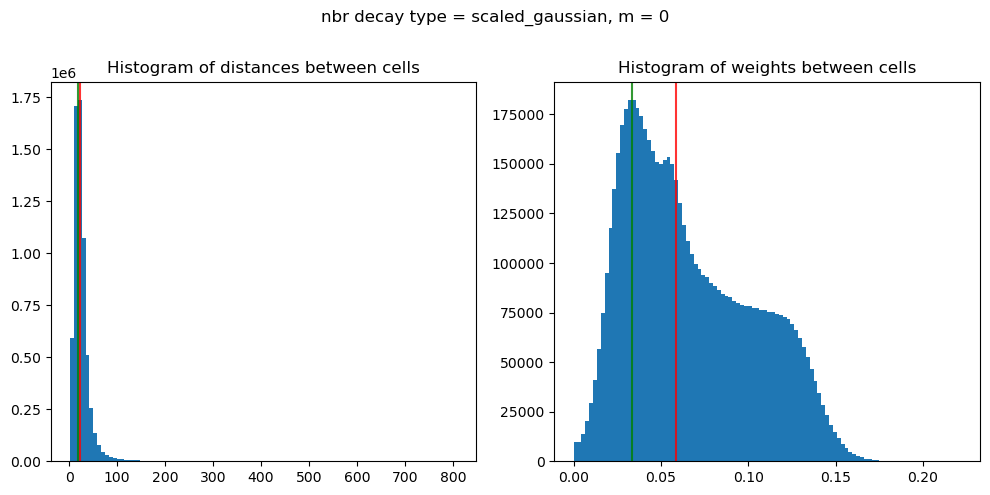

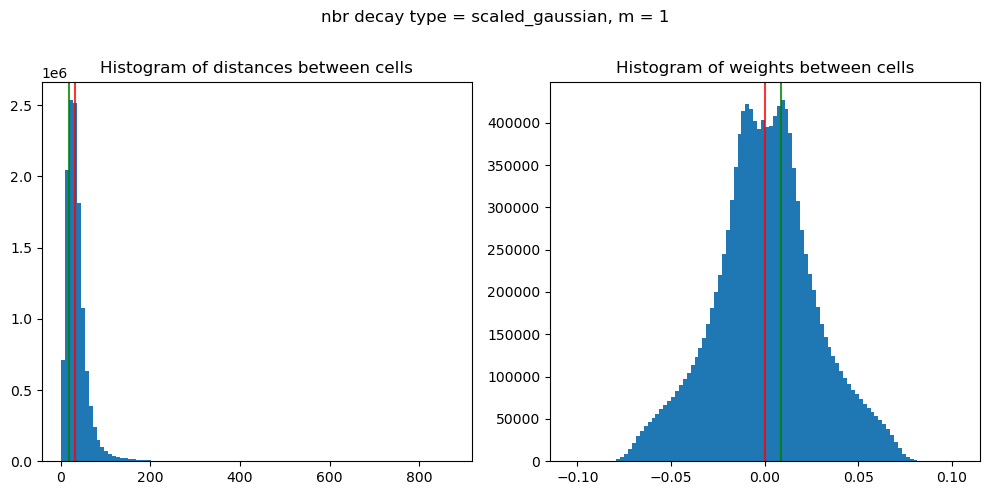

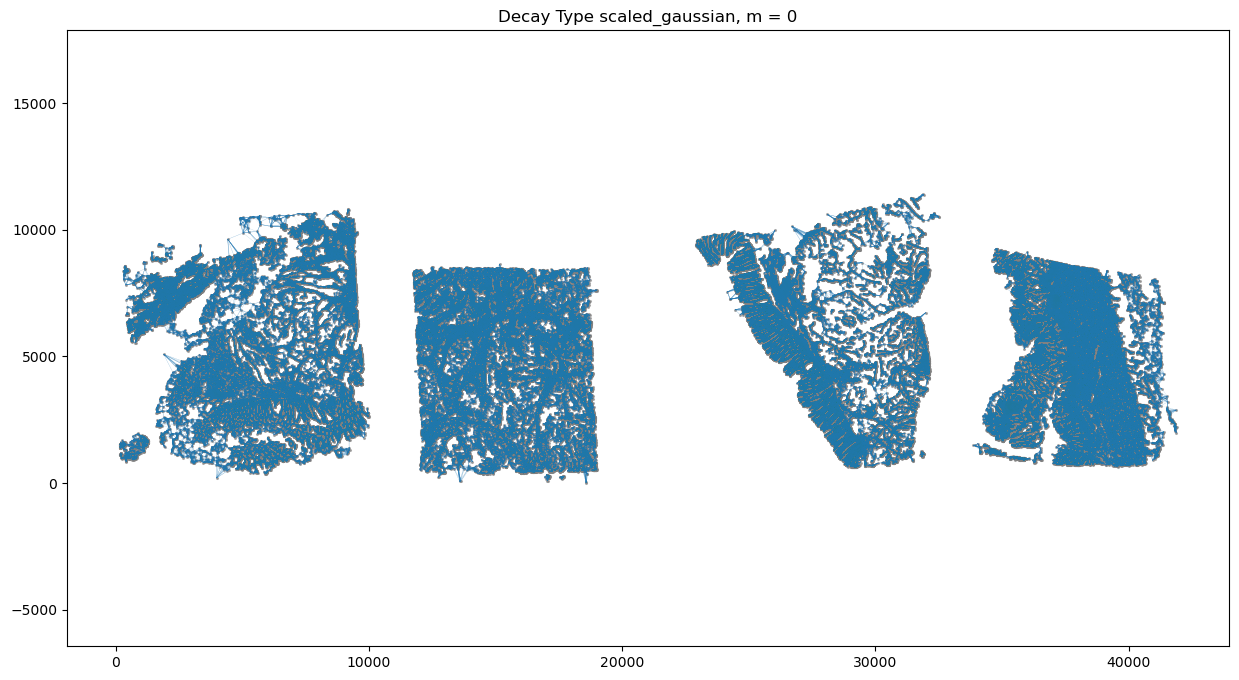

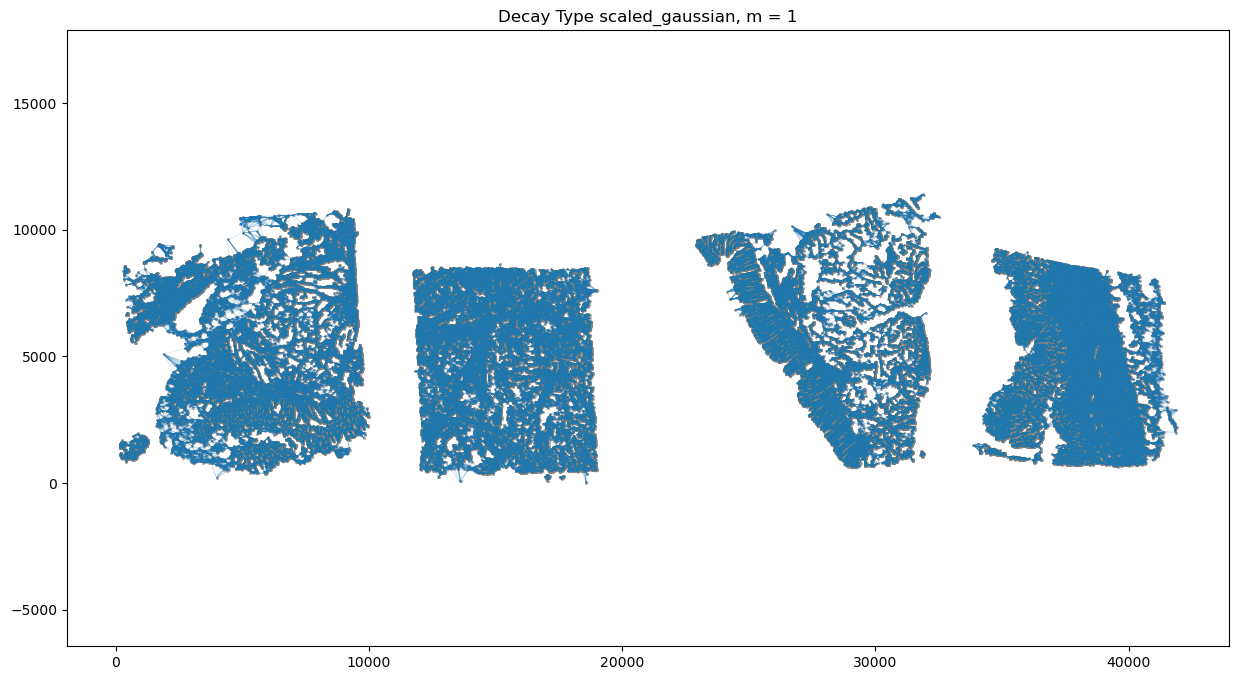

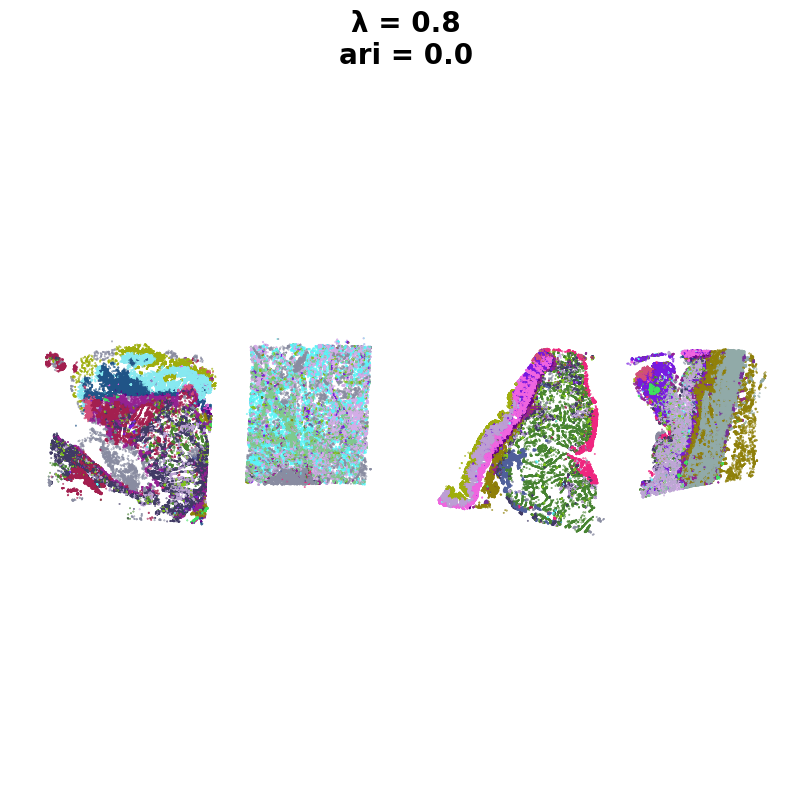

In [51]:
adata_tme,adata_banksy=domains_by_banksy(adata_tme,plot_path=plot_path,banksy_params=banksy_params)

In [55]:
adata_tme

AnnData object with n_obs × n_vars = 418608 × 342
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample', 'n_genes', 'n_counts', 'leiden_3_0', 'leiden_1_0', 'unique_id', 'combined_clusters', 'unique_cell_id', 'Xres', 'Yres', 'default_clustering', 'banksy_domain'
    uns: 'combined_clusters_colors', 'leiden_1_0', 'leiden_3_0', 'leiden_3_0_colors', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'spatial', 'spatial_sample_specific'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [54]:
adata_tme.write('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering_obsm_with_domains_MARIA.h5ad')

In [2]:
import scanpy as sc
adata=sc.read('/media/external/testserver/maria_e/CRC/CRC/xenium_processing/combined_adata/combined_clustering_obsm_with_domains_MARIA.h5ad')

/home/maria_e/anaconda3/envs/banksy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 418608 × 342
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample', 'n_genes', 'n_counts', 'leiden_3_0', 'leiden_1_0', 'unique_id', 'combined_clusters', 'unique_cell_id', 'Xres', 'Yres', 'default_clustering', 'banksy_domain'
    uns: 'combined_clusters_colors', 'leiden_1_0', 'leiden_3_0', 'leiden_3_0_colors', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_umap', 'spatial', 'spatial_sample_specific'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

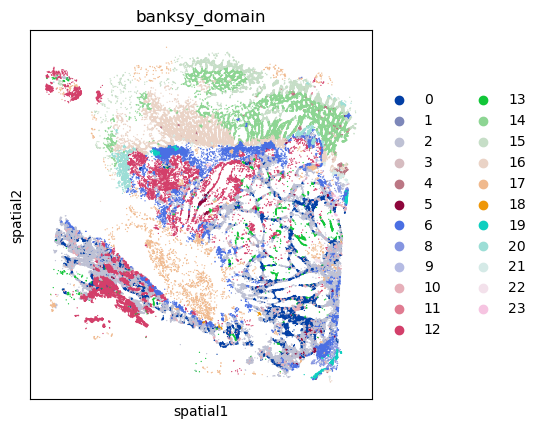

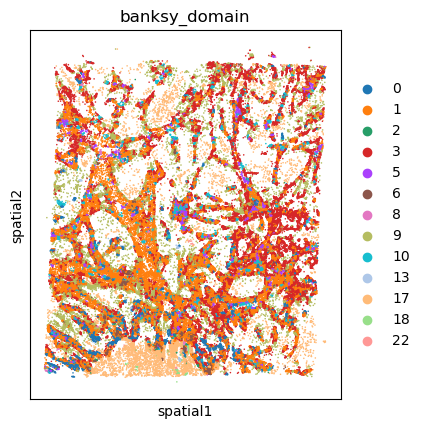

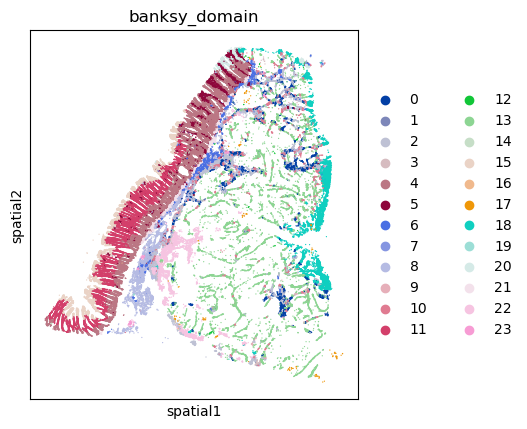

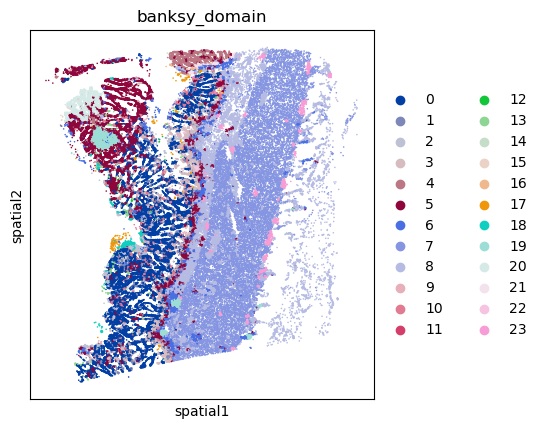

In [56]:
for s in adata_tme.obs['sample'].unique():
        adatasub=adata_tme[adata_tme.obs['sample']==s]
        sc.pl.spatial(adatasub,color='banksy_domain',spot_size=40)

In [59]:
import pandas as pd
pd.crosstab(adata_tme.obs['combined_clusters'],adata_tme.obs['banksy_domain'])

banksy_domain,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
combined_clusters,,,,,,,,,,,,,,,,,,,,,
??_1,2454,3301,2325,4072,12,681,295,97,240,667,...,1,64,4,175,51,10,6,14,13,18
??_2,82,81,85,36,6,87,106,10749,536,9,...,4,6,2,68,4,22,5,6,1,140
??_3,67,37,78,6,8,56,50,1422,610,2,...,1,6,0,39,2,12,0,6,0,714
??_4,131,66,302,39,2,63,141,103,472,8,...,2,2,0,14,44,3,0,16,0,6
??_5,1,0,0,0,9,6,3,0,0,0,...,0,0,2,0,0,0,0,3,0,0
B cell_1,62,400,83,72,5,821,1124,32,328,107,...,4,8,9,147,30,5576,10,13,0,7
B cell_2,320,186,780,96,24,332,331,25,88,45,...,0,29,7,519,3201,11,30,8,14,6
T cell?_3,3086,920,1526,1041,44,981,399,49,144,444,...,11,27,6,162,180,15,43,19,5,18
T cell_1,3234,5623,4797,2760,77,2516,4758,315,925,1737,...,23,155,25,257,221,388,70,59,15,51


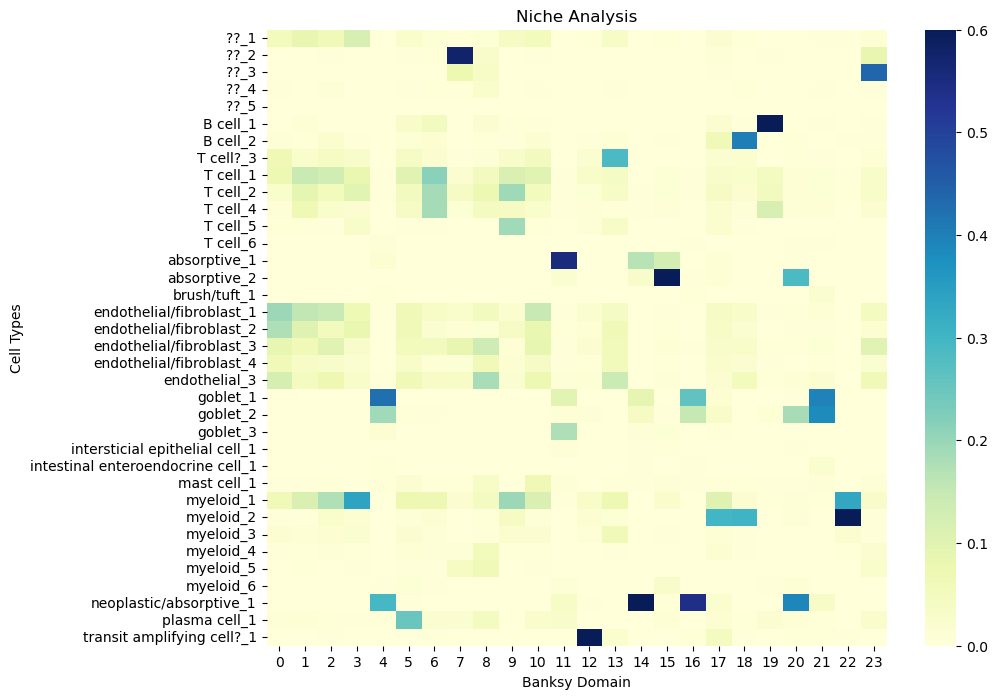

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#To normalize your crosstab so that the cell types are comparable between the niches, you can normalize each row of the crosstabulation matrix by the total number of cells in each niche. This way, you'll be comparing the relative proportions of each cell type within each niche.
# Assuming you've already calculated the crosstab
crosstab_data = pd.crosstab(adata_tme.obs['combined_clusters'], adata_tme.obs['banksy_domain'])

# Calculate the sum of cells for each niche
sums_by_niche = crosstab_data.sum(axis=0)

# Normalize each row by the sum of cells in its respective niche
normalized_crosstab = crosstab_data.div(sums_by_niche, axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_crosstab, cmap="YlGnBu",vmax=0.6)
plt.title('Niche Analysis')
plt.xlabel('Banksy Domain')
plt.ylabel('Cell Types')
plt.show()